In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as plots
from metpy.io import Level3File
from metpy.cbook import get_test_data
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from datetime import datetime, timedelta
from siphon.simplewebservice.wyoming import WyomingUpperAir
from siphon.catalog import TDSCatalog
from siphon.radarserver import RadarServer
from siphon.cdmr import Dataset
import numpy as np
from netCDF4 import Dataset, num2date

%matplotlib inline

#Imports useful modules

# Storm Track

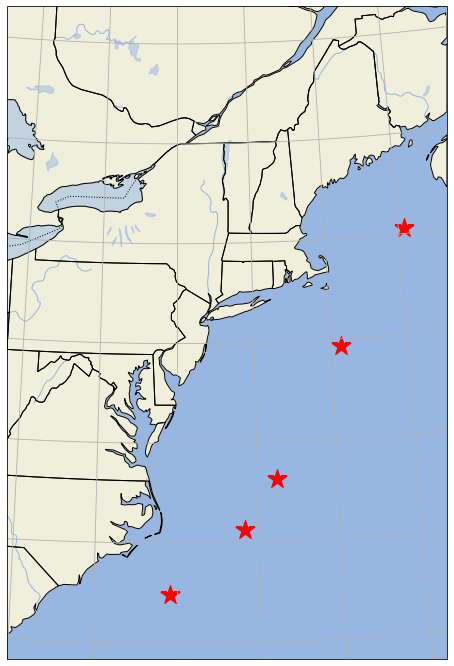

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(18, southern_hemisphere=False))
#Assigns a shorthand name of fig to display the figure and ax to add map features with a projection of 
#UTM Zone 18N
ax.add_feature(cfeat.OCEAN)
ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.LAKES, alpha=0.5)
ax.add_feature(cfeat.RIVERS)
ax.add_feature(cfeat.BORDERS, linestyle=':')


#Adds plot features

state_borders = cfeat.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                          scale='50m', facecolor='none')
#Imports a state borders features from the Natural Earth dataset path and removes the inside color

ax.add_feature(state_borders, edgecolor='black')
#Adds state borders to the figure and makes the lines black

ax.gridlines()
ax.scatter(480897.41, 3728458.31, marker='*', s=400, c='r')
ax.scatter(689476.47, 3908456.80, marker='*', s=400, c='r')
ax.scatter(241757.57, 4049692.52, transform=ccrs.UTM(19, southern_hemisphere=False), marker='*', s=400, c='r')
ax.scatter(442351.19, 4408631.64, transform=ccrs.UTM(19, southern_hemisphere=False), marker='*', s=400, c='r')
ax.scatter(638858.37, 4721075.50, transform=ccrs.UTM(19, southern_hemisphere=False), marker='*', s=400, c='r')
#Plots the south to north track of the center of the cyclone as red stars 

ax.set_extent((-80, -65, 32, 48))
#Sets the extent to Northeastern US

# CAPE/CIN Calculation

In [15]:
date = datetime(2018, 1, 5, 0)

station1 = 'IAD'
station2 = 'GYX'
station3 = 'OKX'
station4 = 'WAL'
station5 = 'ALB'

df1 = WyomingUpperAir.request_data(date, station1)
df2 = WyomingUpperAir.request_data(date, station2)
df3 = WyomingUpperAir.request_data(date, station3)
df4 = WyomingUpperAir.request_data(date, station4)
df5 = WyomingUpperAir.request_data(date, station5)
#Grab data for the 5 stations

In [16]:
p1 = df1['pressure'].values * units(df1.units['pressure'])
T1 = df1['temperature'].values * units(df1.units['temperature'])
Td1 = df1['dewpoint'].values * units(df1.units['dewpoint'])
h1 = df1['height'].values * units(df1.units['height'])

p2 = df2['pressure'].values * units(df2.units['pressure'])
T2 = df2['temperature'].values * units(df2.units['temperature'])
Td2 = df2['dewpoint'].values * units(df2.units['dewpoint'])
h2 = df2['height'].values * units(df2.units['height'])

p3 = df3['pressure'].values * units(df3.units['pressure'])
T3 = df3['temperature'].values * units(df3.units['temperature'])
Td3 = df3['dewpoint'].values * units(df3.units['dewpoint'])
h3 = df3['height'].values * units(df3.units['height'])

p4 = df4['pressure'].values * units(df4.units['pressure'])
T4 = df4['temperature'].values * units(df4.units['temperature'])
Td4 = df4['dewpoint'].values * units(df4.units['dewpoint'])
h4 = df4['height'].values * units(df4.units['height'])

p5 = df5['pressure'].values * units(df5.units['pressure'])
T5 = df5['temperature'].values * units(df5.units['temperature'])
Td5 = df5['dewpoint'].values * units(df5.units['dewpoint'])
h5 = df5['height'].values * units(df5.units['height'])
#Read the data

# Limit pressure to values above 500 mb
idx4 = p4.m > 500

p4new=p4[idx4]
T4new=T4[idx4]
Td4new=Td4[idx4]

# Limit pressure to values above 500 mb
idx5 = p5.m > 500

p5new=p5[idx5]
T5new=T5[idx5]
Td5new=Td5[idx5]

In [17]:
print(mpcalc.most_unstable_cape_cin(p1, T1, Td1))
print(mpcalc.most_unstable_cape_cin(p2, T2, Td2))
print(mpcalc.most_unstable_cape_cin(p3, T3, Td3))
print(mpcalc.most_unstable_cape_cin(p4new, T4new, Td4new))
print(mpcalc.most_unstable_cape_cin(p5new, T5new, Td5new))

(<Quantity(0, 'joule / kilogram')>, <Quantity(0, 'joule / kilogram')>)
(<Quantity(0, 'joule / kilogram')>, <Quantity(0, 'joule / kilogram')>)
(<Quantity(0, 'joule / kilogram')>, <Quantity(0, 'joule / kilogram')>)
(<Quantity(0, 'joule / kilogram')>, <Quantity(0, 'joule / kilogram')>)
(<Quantity(0, 'joule / kilogram')>, <Quantity(0, 'joule / kilogram')>)


# LFC, LCL, and EL Calculation and Sounding Creation

In [18]:
date = datetime(2018, 1, 5, 0)

station1 = 'IAD'
station2 = 'GYX'
station3 = 'OKX'
station4 = 'WAL'
station5 = 'ALB'

df1 = WyomingUpperAir.request_data(date, station1)
df2 = WyomingUpperAir.request_data(date, station2)
df3 = WyomingUpperAir.request_data(date, station3)
df4 = WyomingUpperAir.request_data(date, station4)
df5 = WyomingUpperAir.request_data(date, station5)
#Grab data for the 5 stations

In [19]:
p1 = df1['pressure'].values * units(df1.units['pressure'])
T1 = df1['temperature'].values * units(df1.units['temperature'])
Td1 = df1['dewpoint'].values * units(df1.units['dewpoint'])
u1 = df1['u_wind'].values * units(df1.units['u_wind'])
v1 = df1['v_wind'].values * units(df1.units['v_wind'])

p2 = df2['pressure'].values * units(df2.units['pressure'])
T2 = df2['temperature'].values * units(df2.units['temperature'])
Td2 = df2['dewpoint'].values * units(df2.units['dewpoint'])
u2 = df2['u_wind'].values * units(df2.units['u_wind'])
v2 = df2['v_wind'].values * units(df2.units['v_wind'])

p3 = df3['pressure'].values * units(df3.units['pressure'])
T3 = df3['temperature'].values * units(df3.units['temperature'])
Td3 = df3['dewpoint'].values * units(df3.units['dewpoint'])
u3 = df3['u_wind'].values * units(df3.units['u_wind'])
v3 = df3['v_wind'].values * units(df3.units['v_wind'])

p4 = df4['pressure'].values * units(df4.units['pressure'])
T4 = df4['temperature'].values * units(df4.units['temperature'])
Td4 = df4['dewpoint'].values * units(df4.units['dewpoint'])
u4 = df4['u_wind'].values * units(df4.units['u_wind'])
v4 = df4['v_wind'].values * units(df4.units['v_wind'])

p5 = df5['pressure'].values * units(df5.units['pressure'])
T5 = df5['temperature'].values * units(df5.units['temperature'])
Td5 = df5['dewpoint'].values * units(df5.units['dewpoint'])
u5 = df5['u_wind'].values * units(df5.units['u_wind'])
v5 = df5['v_wind'].values * units(df5.units['v_wind'])
#Read the data

In [20]:
# Limit pressure to values above 500 mb
idx4 = p4.m > 500

p4new=p4[idx4]
T4new=T4[idx4]
Td4new=Td4[idx4]
u4new=u4[idx4]
v4new=v4[idx4]

# Limit pressure to values above 500 mb
idx5 = p5.m > 500

p5new=p5[idx5]
T5new=T5[idx5]
Td5new=Td5[idx5]
u5new=u5[idx5]
v5new=v5[idx5]

# Station 1- Washington, DC (KIAD)

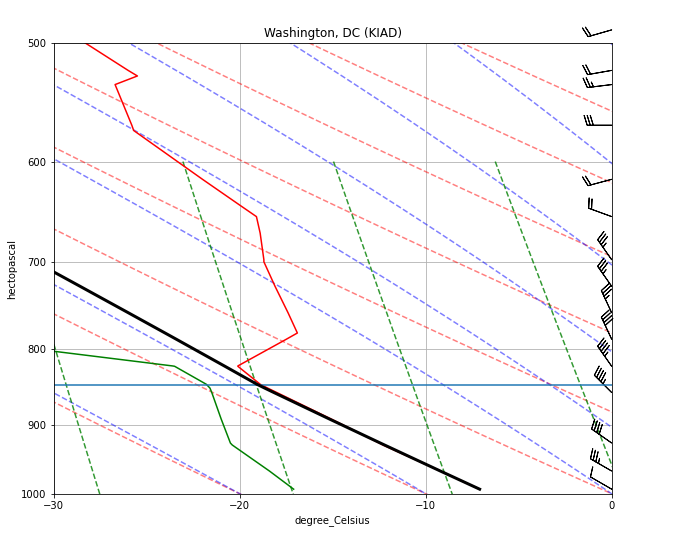

In [21]:
lfc_pressure, lfc_temperature = mpcalc.lfc(p1, T1, Td1)
lcl_pressure, lcl_temperature = mpcalc.lcl(p1[0], T1[0], Td1[0])
el_pressure, el_temperature = mpcalc.el(p1, T1, Td1)

np.logspace(2, 3)
interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(p1, interval)

fig1 = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig1, 180)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.plot(p1, T1, 'red')
skew.plot(p1, Td1, 'green')
skew.ax.set_ylim(1000, 500)
skew.ax.set_xlim(-30, 0)
skew.plot_barbs(p1[idx], u1[idx], v1[idx])
plt.title('Washington, DC (KIAD)', loc='center')

skew.ax.axhline(lcl_pressure)
if lfc_pressure:
    skew.ax.axhline(lfc_pressure)
elif el_pressure:
    skew.ax.axhline(el_pressure)
    
parcel_path = mpcalc.parcel_profile(p1, T1[0], Td1[0])
skew.plot(p1, parcel_path,linewidth=3 , color='k')
#Creates a skew-T diagram with wind barbs spaced out, the parcel path in black, and the lcl in solid blue

# Station 2- Portland, Maine (KGYX)

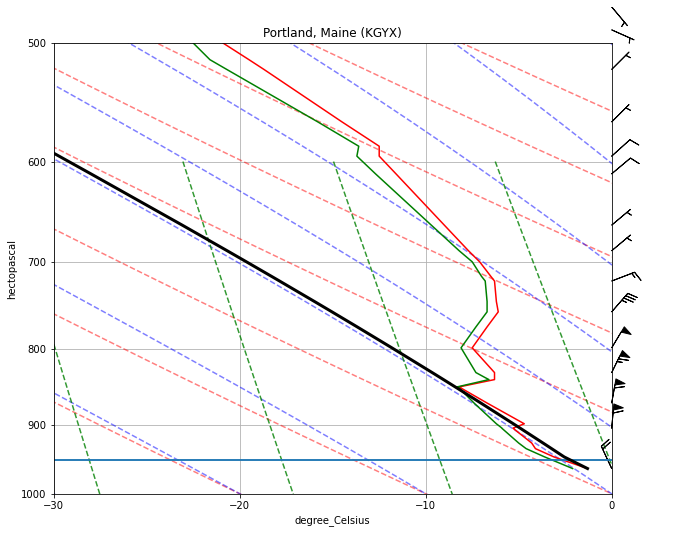

In [22]:
lfc_pressure, lfc_temperature = mpcalc.lfc(p2, T2, Td2)
lcl_pressure, lcl_temperature = mpcalc.lcl(p2[0], T2[0], Td2[0])
el_pressure, el_temperature = mpcalc.el(p2, T2, Td2)

np.logspace(2, 3)
interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(p2, interval)

fig2 = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig2, 180)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.plot(p2, T2, 'red')
skew.plot(p2, Td2, 'green')
skew.ax.set_ylim(1000, 500)
skew.ax.set_xlim(-30, 0)
skew.plot_barbs(p2[idx], u2[idx], v2[idx])
plt.title('Portland, Maine (KGYX)', loc='center')

skew.ax.axhline(lcl_pressure)
if lfc_pressure:
    skew.ax.axhline(lfc_pressure)
elif el_pressure:
    skew.ax.axhline(el_pressure)
    
parcel_path = mpcalc.parcel_profile(p2, T2[0], Td2[0])
skew.plot(p2, parcel_path,linewidth=3 , color='k')

# Station 3- Upton, New York (KOKX)

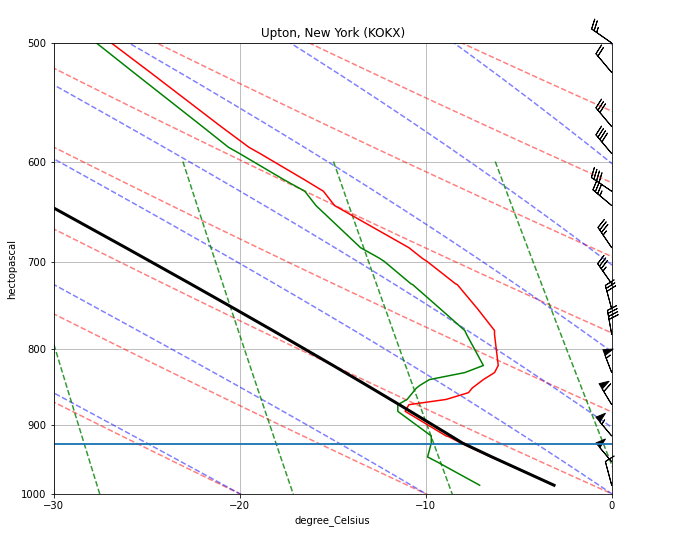

In [23]:
lfc_pressure, lfc_temperature = mpcalc.lfc(p3, T3, Td3)
lcl_pressure, lcl_temperature = mpcalc.lcl(p3[0], T3[0], Td3[0])
el_pressure, el_temperature = mpcalc.el(p3, T3, Td3)

np.logspace(2, 3)
interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(p3, interval)

fig3 = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig3, 180)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.plot(p3, T3, 'red')
skew.plot(p3, Td3, 'green')
skew.ax.set_ylim(1000, 500)
skew.ax.set_xlim(-30, 0)
skew.plot_barbs(p3[idx], u3[idx], v3[idx])
plt.title('Upton, New York (KOKX)', loc='center')

skew.ax.axhline(lcl_pressure)
if lfc_pressure:
    skew.ax.axhline(lfc_pressure)
elif el_pressure:
    skew.ax.axhline(el_pressure)
    
parcel_path = mpcalc.parcel_profile(p3, T3[0], Td3[0])
skew.plot(p3, parcel_path,linewidth=3 , color='k')

# Station 4- Wallops, Virginia (KWAL)

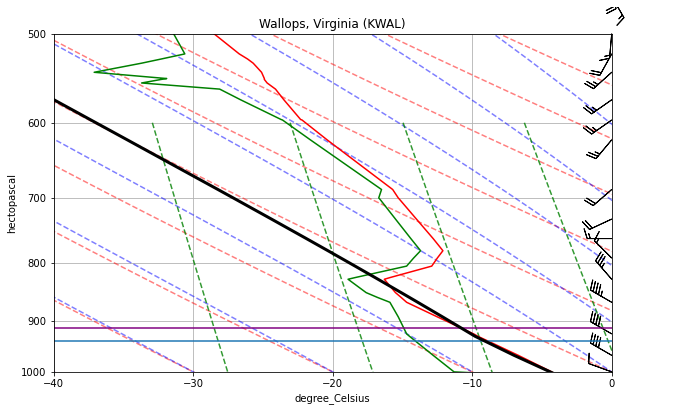

In [24]:
lfc_pressure, lfc_temperature = mpcalc.lfc(p4new, T4new, Td4new)
el_pressure, el_temperature = mpcalc.el(p4new, T4new, Td4new)
lcl_pressure, lcl_temperature = mpcalc.lcl(p4[0], T4[0], Td4[0])

np.logspace(2, 3)
interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(p4, interval)

fig4 = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig4, 180)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.plot(p4, T4, 'red')
skew.plot(p4, Td4, 'green')
skew.ax.set_ylim(1000, 500)
skew.ax.set_xlim(-40, 0)
skew.plot_barbs(p4[idx], u4[idx], v4[idx])
plt.title('Wallops, Virginia (KWAL)', loc='center')

skew.ax.axhline(lcl_pressure)
if lfc_pressure:
    skew.ax.axhline(lfc_pressure, color='purple')
elif el_pressure:
    skew.ax.axhline(el_pressure)

parcel_path = mpcalc.parcel_profile(p4new, T4new[0], Td4new[0])
skew.plot(p4new, parcel_path,linewidth=3 , color='k')

# Station 5- Albany, New York (KALB)

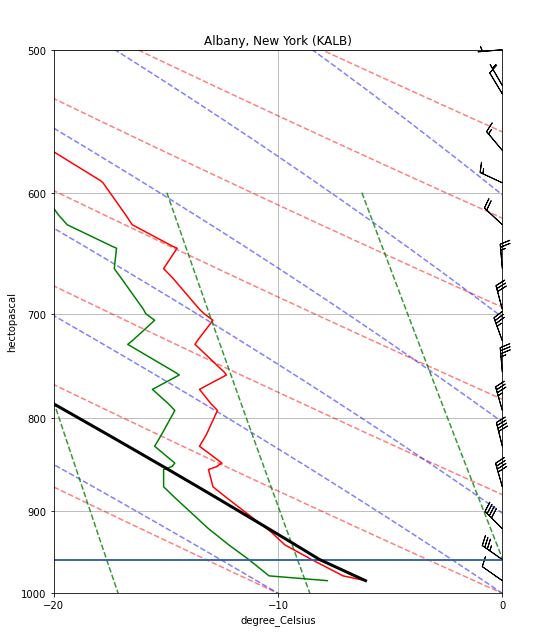

In [25]:
lfc_pressure, lfc_temperature = mpcalc.lfc(p5new, T5new, Td5new)
el_pressure, el_temperature = mpcalc.el(p5new, T5new, Td5new)
lcl_pressure, lcl_temperature = mpcalc.lcl(p5[0], T5[0], Td5[0])

np.logspace(2, 3)
interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(p5, interval)

fig5 = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig5, 180)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.plot(p5, T5, 'red')
skew.plot(p5, Td5, 'green')
skew.ax.set_ylim(1000, 500)
skew.ax.set_xlim(-20, 0)
skew.plot_barbs(p5[idx], u5[idx], v5[idx])
plt.title('Albany, New York (KALB)', loc='center')

if lfc_pressure:
    skew.ax.axhline(lfc_pressure, color='purple')
elif el_pressure:
    skew.ax.axhline(el_pressure)

skew.ax.axhline(lcl_pressure)
parcel_path = mpcalc.parcel_profile(p5new, T5new[0], Td5new[0])
skew.plot(p5new, parcel_path,linewidth=3 , color='k')

# Radar

In [26]:
st1 = Level3File('/home/undead548/Metpy/Radar (28-32)/Data/KENX/2018_01_04_KENX_NWS_NEXRAD_NXL2DPBL_KENX_20180104120000_20180104125959/KENX20180104_120059_V06.ar2v')

IndexError: list index out of range

In [ ]:
time_start='2018-1-5T12:0:0Z'
time_end='2018-1-5T12:0:0Z'
query.stations('ENX', 'DIX', 'GYX').time_range(tstart, tend).variables('N0Q', 'N0H', 'N0M')

In [ ]:
query.stations('FTG', 'INX').time_range(now - timedelta(hours=1), now).variables('N0Q', 'N0C')
query_cat = rs.get_catalog(query)  

In [ ]:
product_codes = ['N0Q', 'N0C', 'N0H']
query_catalogs = []
for product_code in product_codes:
    query.stations('FTG').time_range(now - timedelta(hours=1), now).variables(product_code)
    query_cat = rs.get_catalog(query)
    query_catalogs.append(query_cat)

In [ ]:
query = rs.query()
now = datetime.utcnow()
query.stations('NQA').time_range(now - timedelta(hours=1), now).variables('N0Q')

In [ ]:
query_cat = rs.get_catalog(query)

In [ ]:
print(sorted(query_cat.datasets))

In [ ]:
def plot_radar(data, field_name):
    rng = data.variables['gate'][:]
    az = data.variables['azimuth'][:]
    ref = data.variables[field_name][:]
    
    distance_in_degrees = 3
    ax.set_extent([data.RadarLongitude - distance_in_degrees,
              data.RadarLongitude + distance_in_degrees,
              data.RadarLatitude - distance_in_degrees,
              data.RadarLatitude + distance_in_degrees])
    
    x = rng * np.sin(np.deg2rad(az))[:, None]
    y = rng * np.cos(np.deg2rad(az))[:, None]
    
    norm, cmap = ctables.registry.get_with_range('NWSReflectivity', -30, 100)
    
    mesh = ax.pcolormesh(x, y, ref, norm=norm,cmap=cmap, zorder=0)
    
    return mesh

In [ ]:
field_name = 'BaseReflectivityDR'

base_file = query_cat.datasets[0].remote_access()

proj = cartopy.crs.LambertConformal(central_longitude=data.RadarLongitude,
                                    central_latitude=data.RadarLatitude)

state_borders = cartopy.feature.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes',
    scale= '50m', facecolor='none')

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

artists = []

ax.add_feature(state_borders, edgecolor='black', linewidth=2, zorder=2)

for ds_name in sorted(query_cat.datasets):
    ds = query_cat.datasets[ds_name]
    data = Dataset(ds.access_urls['CdmRemote'])
    
    field_name = [var.name for var in data.variables.values()
                  if var.ndim >= 2 and not var.name.endswith('RAW')][0]
    
    text = ax.text(0.5, 1.02, data.time_coverage_start, ha='center', transform=ax.transAxes)
    
    mesh = plot_radar(data, field_name)
    
    artists.append([text, mesh])

# Satellite Imagery

In [41]:
file_ir = '/home/undead548/Metpy/DATA/Band4/goes13.2018.003.033018.BAND_04.nc'

In [42]:
ds_ir = Dataset(file_ir, 'r')

In [43]:
list(ds_ir.variables)

['version',
 'sensorID',
 'imageDate',
 'imageTime',
 'startLine',
 'startElem',
 'time',
 'dataWidth',
 'lineRes',
 'elemRes',
 'prefixSize',
 'crDate',
 'crTime',
 'bands',
 'auditTrail',
 'data',
 'lat',
 'lon']

In [44]:
ir_10bit = ds_ir.variables['data'][0]/32

/tmp/ipykernel_30493/704371466.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ir_10bit = ds_ir.variables['data'][0]/32


In [45]:
lat_ir = np.ma.masked_values(ds_ir.variables['lat'][:], 2.1432893e+09)
lon_ir = np.ma.masked_values(ds_ir.variables['lon'][:], 2.1432893e+09)

/tmp/ipykernel_30493/2191087902.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat_ir = np.ma.masked_values(ds_ir.variables['lat'][:], 2.1432893e+09)
/tmp/ipykernel_30493/2191087902.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon_ir = np.ma.masked_values(ds_ir.variables['lon'][:], 2.1432893e+09)


In [46]:
ir_masked = np.ma.masked_array(ir_10bit, mask=lat_ir.mask)

In [47]:
m_ir = 5.2285
b_ir = 15.6854

R_ir = (ir_masked - b_ir)/m_ir

In [48]:
# Inverse Planck Function constants
c1 = 1.191066e-5
c2 = 1.438833

In [49]:
# GOES-13 coefficients for Channel 4
n_ir = 937.23
a_ir = -0.386043
b_ir = 1.001298

In [50]:
T_eff_ir = (c2*n_ir)/(np.log(1 + (c1*n_ir**3)/R_ir))

In [51]:
BT_ir = a_ir + b_ir*T_eff_ir
BT_ir.max()

298.10272

/tmp/ipykernel_30493/11686674.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vtime = num2date(ds_ir.variables['time'][:], units=ds_ir.variables['time'].units)
/tmp/ipykernel_30493/11686674.py:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  vtime = num2date(ds_ir.variables['time'][:], units=ds_ir.variables['time'].units)


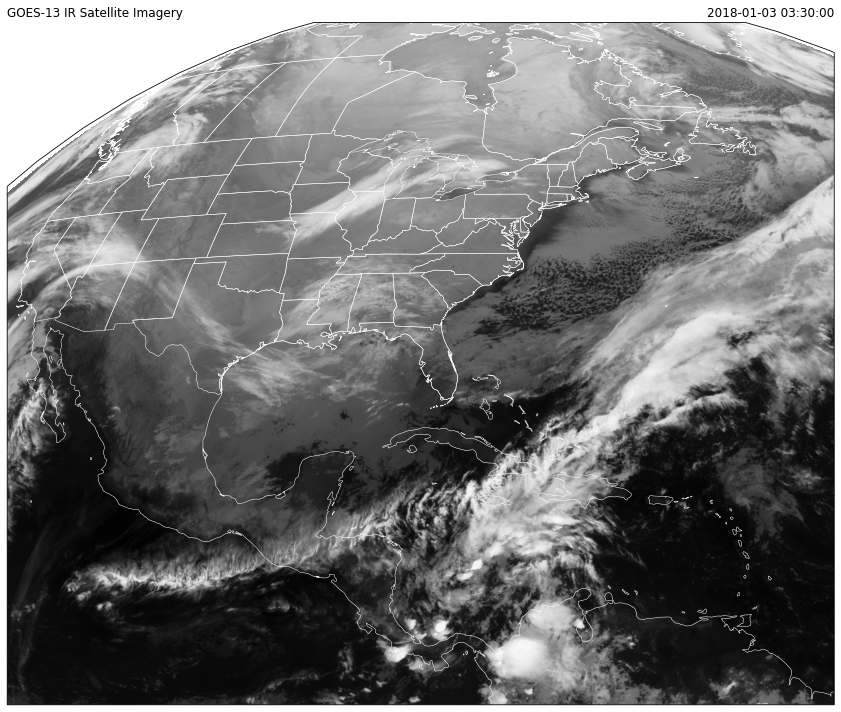

In [52]:
vtime = num2date(ds_ir.variables['time'][:], units=ds_ir.variables['time'].units)

mapcrs = ccrs.Geostationary(central_longitude=-75)

ilon_min = np.unravel_index(np.argmin(lon_ir), lon_ir.shape)
ilon_max = np.unravel_index(np.argmax(lon_ir), lon_ir.shape)
ilat_min = np.unravel_index(np.argmin(lat_ir), lat_ir.shape)
ilat_max = np.unravel_index(np.argmax(lat_ir), lat_ir.shape)

LONpt0 = mapcrs.transform_point(lon_ir[ilon_min], lat_ir[ilon_min], ccrs.Geodetic())[0]
LONpt1 = mapcrs.transform_point(lon_ir[ilon_max], lat_ir[ilon_max], ccrs.Geodetic())[0]
LATpt0 = mapcrs.transform_point(lon_ir[ilat_min], lat_ir[ilat_min], ccrs.Geodetic())[1]
LATpt1 = mapcrs.transform_point(lon_ir[ilat_max], lat_ir[ilat_max], ccrs.Geodetic())[1]

fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_ir, cmap='Greys', origin='upper',
                extent=(LONpt0, LONpt1, LATpt0, LATpt1))

ax.add_feature(cfeat.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)
ax.add_feature(cfeat.STATES.with_scale('50m'), edgecolor='white', linewidth=0.5)

plt.title(vtime[0], loc='right')
plt.title('GOES-13 IR Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

# Video 50

In [53]:
file_wv = '/home/undead548/Metpy/DATA/goes13.2018.004.160018.BAND_03.nc'

In [54]:
ds_wv = Dataset(file_wv, 'r')

In [55]:
wv_10bit = ds_wv.variables['data'][0]/32

/tmp/ipykernel_30493/782586099.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  wv_10bit = ds_wv.variables['data'][0]/32


In [56]:
lat_wv = np.ma.masked_values(ds_wv.variables['lat'][:], 2.1432893e+09)
lon_wv = np.ma.masked_values(ds_wv.variables['lon'][:], 2.1432893e+09)

/tmp/ipykernel_30493/174029937.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat_wv = np.ma.masked_values(ds_wv.variables['lat'][:], 2.1432893e+09)
/tmp/ipykernel_30493/174029937.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon_wv = np.ma.masked_values(ds_wv.variables['lon'][:], 2.1432893e+09)


In [57]:
wv_masked = np.ma.masked_array(wv_10bit, mask=lat_wv.mask)

In [58]:
m_wv = 38.8383
b_wv = 29.1287

R_wv = (wv_masked - b_wv)/m_wv

In [59]:
# GOES-13 coefficients for Channel 3
n_wv = 1522.52
a_wv = -3.625663
b_wv = 1.010018

In [60]:
T_eff_wv = (c2*n_wv)/(np.log(1 + (c1*n_wv**3)/R_wv))

In [61]:
BT_wv = a_wv + b_wv*T_eff_wv
BT_wv.max()

263.97156

/tmp/ipykernel_30493/1500513363.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vtime = num2date(ds_wv.variables['time'][:], units=ds_wv.variables['time'].units)
/tmp/ipykernel_30493/1500513363.py:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  vtime = num2date(ds_wv.variables['time'][:], units=ds_wv.variables['time'].units)


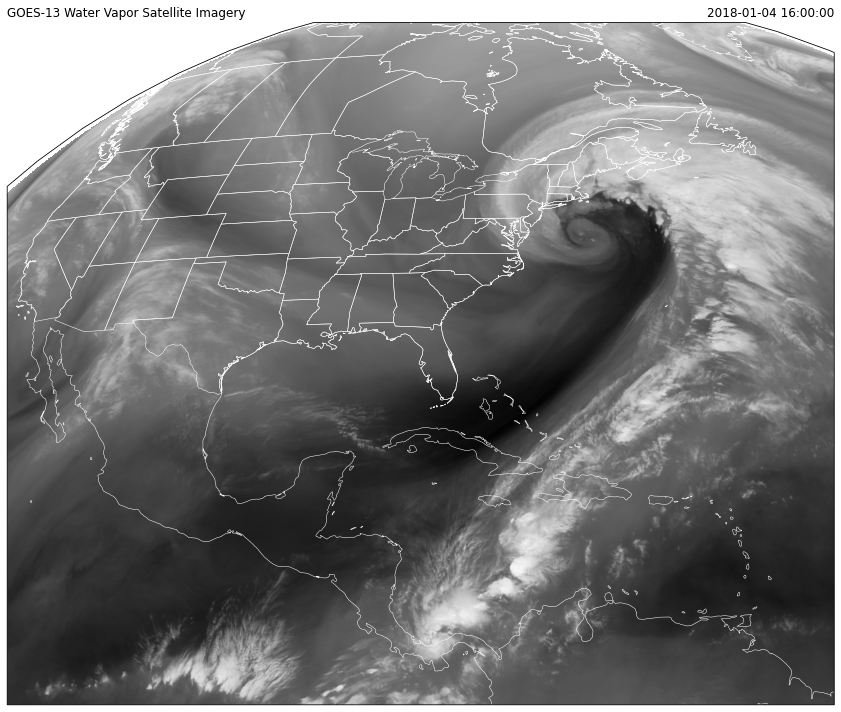

In [62]:
vtime = num2date(ds_wv.variables['time'][:], units=ds_wv.variables['time'].units)

ilon_min = np.unravel_index(np.argmin(lon_wv), lon_wv.shape)
ilon_max = np.unravel_index(np.argmax(lon_wv), lon_wv.shape)
ilat_min = np.unravel_index(np.argmin(lat_wv), lat_wv.shape)
ilat_max = np.unravel_index(np.argmax(lat_wv), lat_wv.shape)

LONpt0 = mapcrs.transform_point(lon_wv[ilon_min], lat_wv[ilon_min], ccrs.Geodetic())[0]
LONpt1 = mapcrs.transform_point(lon_wv[ilon_max], lat_wv[ilon_max], ccrs.Geodetic())[0]
LATpt0 = mapcrs.transform_point(lon_wv[ilat_min], lat_wv[ilat_min], ccrs.Geodetic())[1]
LATpt1 = mapcrs.transform_point(lon_wv[ilat_max], lat_wv[ilat_max], ccrs.Geodetic())[1]

fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_wv, cmap='Greys', origin='upper',
                extent=(LONpt0, LONpt1, LATpt0, LATpt1))

ax.add_feature(cfeat.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)
ax.add_feature(cfeat.STATES.with_scale('50m'), edgecolor='white', linewidth=0.5)

plt.title(vtime[0], loc='right')
plt.title('GOES-13 Water Vapor Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

# Video 51

In [63]:
from metpy.plots import ctables

ir_cmap = ctables.registry.get_colortable('ir_drgb_r')
ir_cmap.set_under('k')

wv_norm, wv_cmap = ctables.registry.get_with_range('WVCIMSS_r', 190, 273)
wv_cmap.set_under('k')

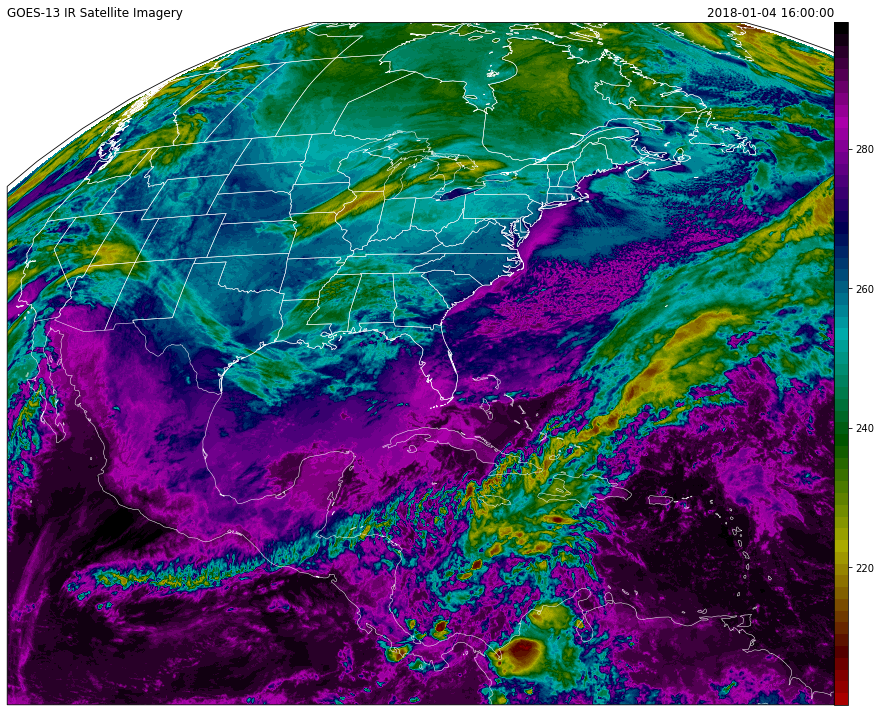

In [64]:
ilon_min = np.unravel_index(np.argmin(lon_ir), lon_ir.shape)
ilon_max = np.unravel_index(np.argmax(lon_ir), lon_ir.shape)
ilat_min = np.unravel_index(np.argmin(lat_ir), lat_ir.shape)
ilat_max = np.unravel_index(np.argmax(lat_ir), lat_ir.shape)

LONpt0 = mapcrs.transform_point(lon_ir[ilon_min], lat_ir[ilon_min], ccrs.Geodetic())[0]
LONpt1 = mapcrs.transform_point(lon_ir[ilon_max], lat_ir[ilon_max], ccrs.Geodetic())[0]
LATpt0 = mapcrs.transform_point(lon_ir[ilat_min], lat_ir[ilat_min], ccrs.Geodetic())[1]
LATpt1 = mapcrs.transform_point(lon_ir[ilat_max], lat_ir[ilat_max], ccrs.Geodetic())[1]

fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_ir, cmap=ir_cmap, origin='upper',
                extent=(LONpt0, LONpt1, LATpt0, LATpt1))
plt.colorbar(img, orientation='vertical', pad=0, aspect=50)

ax.add_feature(cfeat.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)
ax.add_feature(cfeat.STATES.with_scale('50m'), edgecolor='white', linewidth=0.5)

plt.title(vtime[0], loc='right')
plt.title('GOES-13 IR Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

# Water Vapor Image Creation

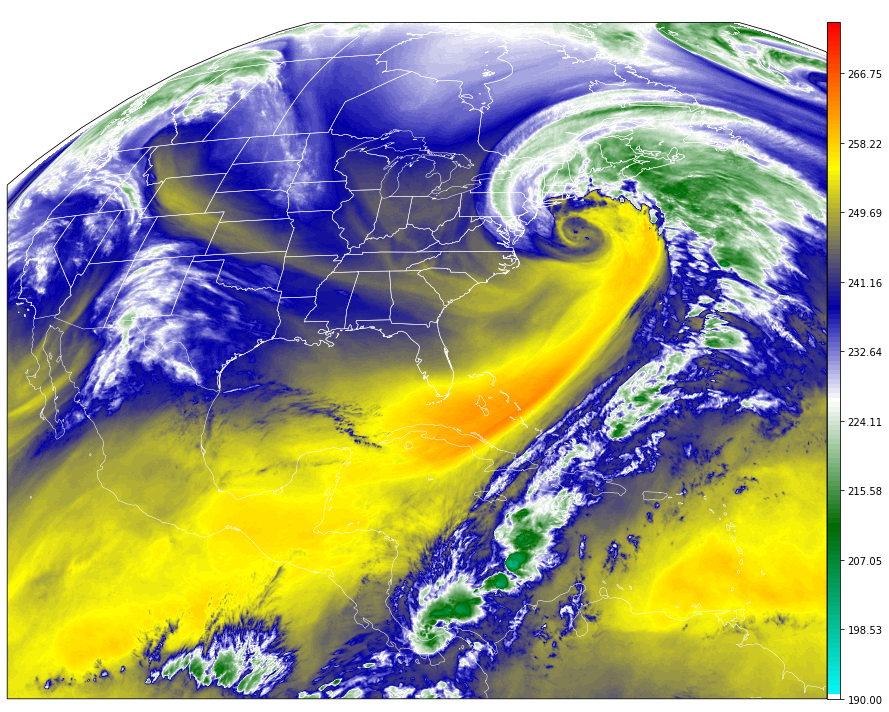

In [65]:
# Get the max and min of lat and lon
ilon_min = np.unravel_index(np.argmin(lon_wv), lon_wv.shape)
ilon_max = np.unravel_index(np.argmax(lon_wv), lon_wv.shape)
ilat_min = np.unravel_index(np.argmin(lat_wv), lat_wv.shape)
ilat_max = np.unravel_index(np.argmax(lat_wv), lat_wv.shape)

# Transform the lat and lon to Geodetic 
LONpt0 = mapcrs.transform_point(lon_wv[ilon_min], lat_wv[ilon_min], ccrs.Geodetic())[0]
LONpt1 = mapcrs.transform_point(lon_wv[ilon_max], lat_wv[ilon_max], ccrs.Geodetic())[0]
LATpt0 = mapcrs.transform_point(lon_wv[ilat_min], lat_wv[ilat_min], ccrs.Geodetic())[1]
LATpt1 = mapcrs.transform_point(lon_wv[ilat_max], lat_wv[ilat_max], ccrs.Geodetic())[1]

# Create a figure with a specified size and projection
fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

# Set the colormap for the image and aling it vertically
img = ax.imshow(BT_wv, cmap=wv_cmap, norm=wv_norm, origin='upper',
                extent=(LONpt0, LONpt1, LATpt0, LATpt1))
plt.colorbar(img, orientation='vertical', pad=0, aspect=50)

# Add Coastlines and States to the plot
ax.add_feature(cfeat.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)
ax.add_feature(cfeat.STATES.with_scale('50m'), edgecolor='white', linewidth=0.5)

# Plot the Title
plt.title(vtime[0], loc='right', c='white')
plt.title('GOES-13 Water Vapor Satellite Imagery', loc='left', c='white')

# Display the Image
plt.tight_layout()
plt.show()

# Written Report

Using MetPy to Diagnose the January 2018 Nor'easter

I. Introduction

	Between January 1st and January 6th of 2018, an extratropical cyclone made its way from the tropics to the poles in a hurricane-like path. For most of its life, the extratropical cyclone did not stand out as unique and only brought a tenth of an inch of snow. This changed on January 3rd when the extratropical cyclone started to rapidly drop in pressure due to the presence of a tropopause fold in the upper atmosphere and turned into a bomb cyclone. By definition, the pressure must drop by 24 mb in 24 hours to be considered a bomb cyclone. Between January 3rd and 4th, the pressure dropped by 53 mb in 21 hours, more than double the required pressure drop. At a peak intensity of 949 mb, the bomb cyclone even developed a feature similar to the eye of a hurricane.
	Along with warm air funneling in from the ocean, the newly intensified bomb cyclone dumped up to  2 feet of snow in the north and half an inch of ice in the south. Despite the decision of many East Coast states to declare a state of emergency, 22 people unfortunately lost their lives and cost around $1.1 billion in damages. A majority of the monetary losses were due to power outages and wind gusts up to 126 mph. This report will use archived data and UCAR’s MetPy python library to diagnose the synoptic features of the event. This will give a better understanding of what happened and how python can be used in meteorology.
    
II. Data Description

	Before discussing the event, this section will talk about the data that was used in the case study. The first source of data is WyomingUpperAir which is a simple web service connected to the University of Wyoming’s upper air database through the use of the siphon python library. This contains basic variables such as pressure, temperature, dew point, u component of wind, and v component of wind. The data allows for the creation of STUVE upper air diagrams for select locations.  These select locations were Washington, DC (KIAD), Portland, Maine (KGYX), Upton, New York (KOKX), Wallops, Virginia (KWAL), and Albany, New York (KALB). All data was collected for 0Z on January 5th, 2018. Another data source that was used was NCEI’s NEXRAD Inventory and Google Cloud Storage. This data source was useful for downloading archived radar data and looking at products such as hydrometer classification and base reflectivity. Data was downloaded for every 3 hours between January 4th 12Z and January 5th 12Z> The last dataset that was used is NOAA’s CLASS system. This data was used to create images of satellite imagery.
    
III. Synoptic Case

	There were a few main factors that caused this bomb cyclone to have the impacts that it did. First of all, Figure 1 below shows the hurricane-like path that the cyclone took parallel to the East Coast.

Figure 1: Path of the January 2018 Nor'easter from south to north. <See storm track section>

Since the path was nearly parallel to the coast, snowfall and freezing rain was allowed to keep affecting the same areas. Especially in states like North Carolina and Virginia,  the impacts before and after explosive cyclogenesis were seen. As the bomb cyclone moved into Canada, islands helped to weaken the cyclone until it dissipated. Along with the path of the storm, the tropopause fold played a huge role in intensifying the system. IDV was used to create Figure 2 below.

Figure 2: Tropopause fold at 0Z on January 5th

The fold created a strong low-level jet that funneled warm air from the ocean into a trowal. This allowed a very high concentration of moisture to set in over the East Coast.
	The last 2 main factors take place in the lower half of the atmosphere and relate to soundings and satellite imagery. Normally, Skew-T diagrams are used for soundings, but a blizzard is better seen on a STUVE. Additionally, the soundings will be limited from 1000 to 500 mb so that important differences can be seen.

Figures 3-7: Soundings from south to north using WyomingUpperAir data (Black= parcel path, horizontal blue line = LCL, horizontal purple line = LFC) <See soundings creation section>

Figure 3 is the only one that has an LFC, but any CAPE that may be there is way too small to have a big impact. For the rest of Figures 3-7, there is not a lot going on thermodynamically. All diagrams are below 0 and much of the snow/ice will be determined by the melting layer. In Figures 5 and 7, winds near 830 mb reach into the 60 knots which is part of the low-level jet mentioned earlier. In Figure 3, 50 knot winds can be seen a little higher at 780 mb. 
	When looking at snow and ice, satellite imagery, reveals quite a bit. Water vapor imagery also shows other points discussed above.
    
Figure 8: Water Vapor Imagery taken around the same time as the soundings. <See satellite imagery section>

In Figure 8, the eye-like feature is almost visible with the TROWAL almost looping back around to the other side of the cyclone. Along with the deep tongue of dry air (tropopause fold), it is easy to see the vast amounts of moisture flowing from the tropics to the impacted area. Another point of interest in the satellite image that can be explain snow/ice can be seen over Virginia, where some parts are dry and other parts are not.

IV. Summary

	Putting everything together, we have a small event that exploded into an intense bomb cyclone late into January 4th. After bombogenesis, a semi-strong low-level jet funneled warm, moist air from the Atlantic Ocean to the Northeastern part of the US. As the bomb cyclone traveled parallel to the East Coast, the same states kept getting buried under snow and ice. In dry parts of Virginia, ice was more of a concern while moist parts saw more snow. Powerful wind gusts provided by the jet also caused blizzard warnings to be issued in many states. 
    
V. References

May, R. M., Arms, S. C., Leeman, J. R., and Chastang, J., 2017:
    	Siphon: A collection of Python Utilities for Accessing Remote Atmospheric
    	and Oceanic Datasets. Unidata, https://github.com/Unidata/siphon, doi:10.5065/D6CN72NW.
May, R. M., Arms, S. C., Marsh, P., Bruning, E., Leeman, J. R., Goebbert, K., Thielen, J. E.,
    	Bruick, Z., and Camron, M. D., 2022: MetPy: A Python Package for Meteorological Data.
    	Unidata, https://github.com/Unidata/MetPy, doi:10.5065/D6WW7G29. 
NOAA/NCEI, 2017: Historical Radar Data in Google Cloud. NOAA/National Centers for Environmental Information.Subset         used: January, 2018, https://www.ncei.noaa.gov/news/historical-radar-data-google-cloud.
NOAA: Comprehensive Large Array-Data Stewardship System (CLASS). Subset used: January, 	2018,                             https://www.avl.class.noaa.gov/saa/products/welcome. 